## Anomaly Detection Made Easy

Contrary to what many data science courses suggest, not all datasets are perfectly curated collections of observations without missing values or outliers (e.g., the mtcars and iris datasets). In reality, data is often messy, requiring us to clean and organize it into a usable format before beginning any analysis. Data cleaning may not be the most exciting task, but it's a crucial step in solving real-world data science problems. In this notebook, I will explain what outliers are, their different types, how to detect them, and the steps you can take to address them.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

from pathlib import Path

An Anomaly lier is an observation that is unlike the other observations. It is rare, or distinct, or does not fit in some way. It is also called outliers. They, however can have lots of causes, namely:

- Measurement or input error
- Data corruption
- True anomaly observation

There is no precise way to define and identify anomalies in general because of the specifics of each dataset. Instead, you, or a domain expert, must interpret the raw observations and decide whether a value is an outlier or not.

Nevertheless, we can use statistical methods to identify observations that appear to be rare or unlikely given the available data. This does not mean that the values identified are outliers and should be removed. A good tip is to consider plotting the identified outlier values, perhaps in the context of non-outlier values to see if there are any systematic relationships or patterns to the outliers. If there is, perhaps they are not outliers and can be explained, or perhaps the outliers themselves can be identified more systematically

In [49]:
df_1 = pd.read_csv("heart_disease_uci.csv")
df_1.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [50]:
df_1.isnull().sum()


id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [51]:
df_1.describe()


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


<Axes: ylabel='chol'>

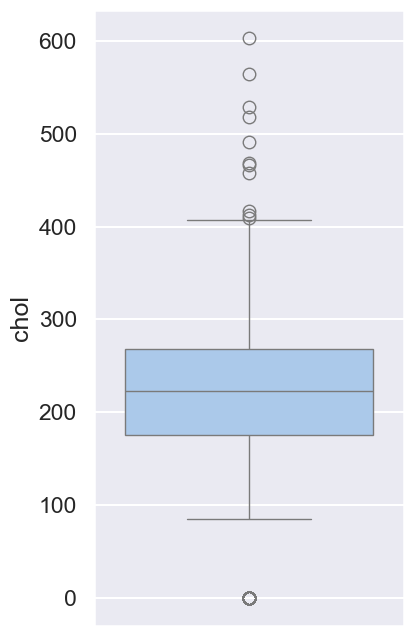

In [52]:
plt.figure(figsize = (4,8))
sns.boxplot(y = df_1.chol)

In [53]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [54]:
out_iqr(df_1,'chol')


The IQR is nan
The lower bound value is nan
The upper bound value is nan
Total number of outliers are 0


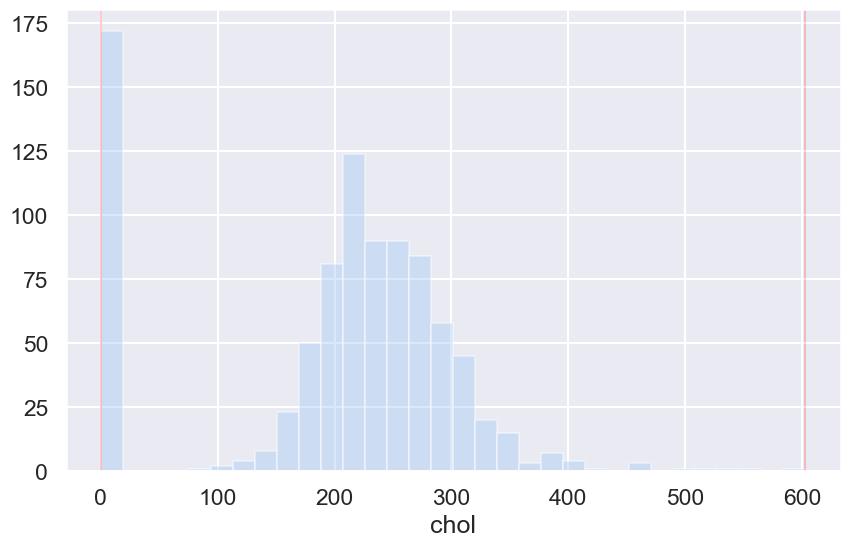

In [55]:
plt.figure(figsize = (10,6))
sns.distplot(df_1.chol, kde=False)
plt.axvspan(xmin = lower,xmax= df_1.chol.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_1.chol.max(),alpha=0.2, color='red')

In [56]:
#Data Frame without outliers
df_new = df_1[(df_1['chol'] < upper) | (df_1['chol'] > lower)]

In [57]:
df = pd.read_csv('heart_disease_uci.csv')

# Map categorical values to numerical codes
sex_mapping = {'Male': 1, 'Female': 0}
cp_mapping = {
    'typical angina': 3, 
    'atypical angina': 2, 
    'non-anginal': 1, 
    'asymptomatic': 0
}
restecg_mapping = {'normal': 0, 'lv hypertrophy': 1, 'st-t abnormality': 2}
slope_mapping = {'upsloping': 2, 'flat': 1, 'downsloping': 0}
thal_mapping = {'normal': 1, 'fixed defect': 2, 'reversable defect': 3}

# Apply the mappings to the relevant columns
df['sex'] = df['sex'].map(sex_mapping)
df['cp'] = df['cp'].map(cp_mapping)
df['restecg'] = df['restecg'].map(restecg_mapping)
df['slope'] = df['slope'].map(slope_mapping)
df['thal'] = df['thal'].map(thal_mapping)

# Rename the columns
df.rename(columns={'thalch': 'thalach', 'num': 'target'}, inplace=True)

# Drop the unnecessary columns
df = df.drop(columns=['id', 'dataset'])

# Save the transformed data to a new CSV file
df.to_csv('heart.csv', index=False)

In [58]:
df_1 = pd.read_csv("heart.csv")
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,True,1.0,150.0,False,2.3,0.0,0.0,2.0,0
1,67,1,0,160.0,286.0,False,1.0,108.0,True,1.5,1.0,3.0,1.0,2
2,67,1,0,120.0,229.0,False,1.0,129.0,True,2.6,1.0,2.0,3.0,1
3,37,1,1,130.0,250.0,False,0.0,187.0,False,3.5,0.0,0.0,1.0,0
4,41,0,2,130.0,204.0,False,1.0,172.0,False,1.4,2.0,0.0,1.0,0


In [59]:
df_1.isnull().sum()


age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [60]:
df_1.describe()


,age,sex,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal,target
count,920.000000,920.000000,920.000000,861.000000,890.000000,918.000000,865.000000,858.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,0.750000,132.132404,199.130337,0.594771,137.545665,0.878788,1.229133,0.676375,1.990783,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.794786,25.926276,1.091226,0.619256,0.935653,0.946567,1.142693
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,1.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,175.000000,0.000000,120.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,140.000000,0.500000,1.000000,0.000000,2.000000,1.000000
75%,60.000000,1.000000,1.000000,140.000000,268.000000,1.000000,157.000000,1.500000,2.000000,1.000000,3.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,2.000000,202.000000,6.200000,2.000000,3.000000,3.000000,4.000000


<Axes: ylabel='chol'>

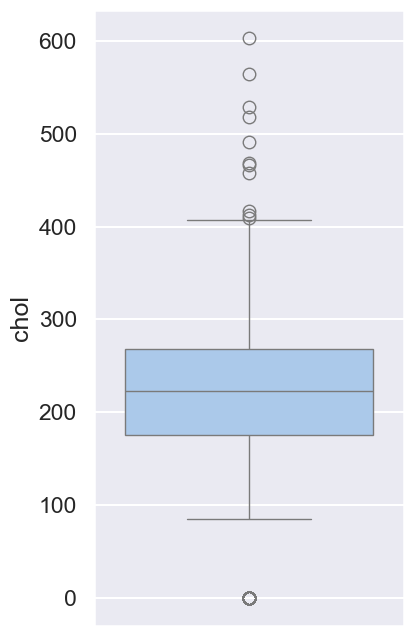

In [61]:
plt.figure(figsize = (4,8))
sns.boxplot(y = df_1.chol)

In [62]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [63]:
out_iqr(df_1,'chol')


The IQR is nan
The lower bound value is nan
The upper bound value is nan
Total number of outliers are 0


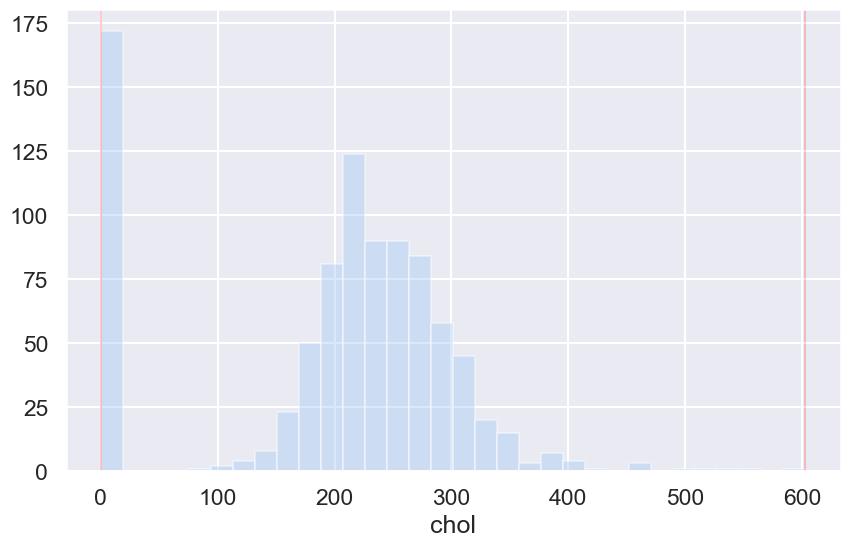

In [64]:
plt.figure(figsize = (10,6))
sns.distplot(df_1.chol, kde=False)
plt.axvspan(xmin = lower,xmax= df_1.chol.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_1.chol.max(),alpha=0.2, color='red')

In [90]:
df_new = df_1[(df_1['chol'] < upper) | (df_1['chol'] > lower)]
df_new.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,True,1.0,150.0,False,2.3,0.0,0.0,2.0,0
1,67,1,0,160.0,286.0,False,1.0,108.0,True,1.5,1.0,3.0,1.0,2
2,67,1,0,120.0,229.0,False,1.0,129.0,True,2.6,1.0,2.0,3.0,1
3,37,1,1,130.0,250.0,False,0.0,187.0,False,3.5,0.0,0.0,1.0,0
4,41,0,2,130.0,204.0,False,1.0,172.0,False,1.4,2.0,0.0,1.0,0


In [91]:
df_new.describe()

,age,sex,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal,target
count,890.000000,890.000000,890.000000,834.000000,890.000000,888.000000,838.000000,831.000000,603.000000,308.000000,432.000000,890.000000
mean,53.580899,0.789888,0.743820,132.089928,199.130337,0.604730,137.539379,0.889290,1.230514,0.678571,1.990741,1.008989
std,9.389502,0.407617,0.932835,19.077093,110.780810,0.797587,25.989709,1.095398,0.619397,0.936378,0.946312,1.145210
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,1.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,175.000000,0.000000,120.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,140.000000,0.500000,1.000000,0.000000,2.000000,1.000000
75%,60.000000,1.000000,1.000000,140.000000,268.000000,1.000000,157.000000,1.500000,2.000000,1.000000,3.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,2.000000,202.000000,6.200000,2.000000,3.000000,3.000000,4.000000


In [66]:
df_2 = pd.read_csv("StudentsPerformance.csv")
df_2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


<Axes: xlabel='writing score', ylabel='Density'>

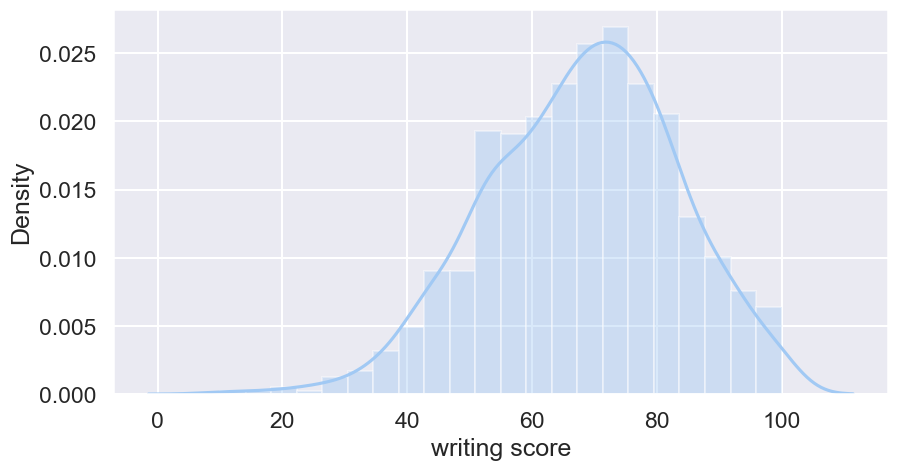

In [67]:
plt.figure(figsize = (10,5))
sns.distplot(df_2['writing score'])

In [68]:
def out_std(df, column):
    global lower,upper
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
    # calculate the cutoff value
    cut_off = data_std * 3
    # calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [69]:
out_std(df_2,'writing score')


The lower bound value is 22.46702896739105
The upper bound value is 113.64097103260895
Total number of outliers are 4


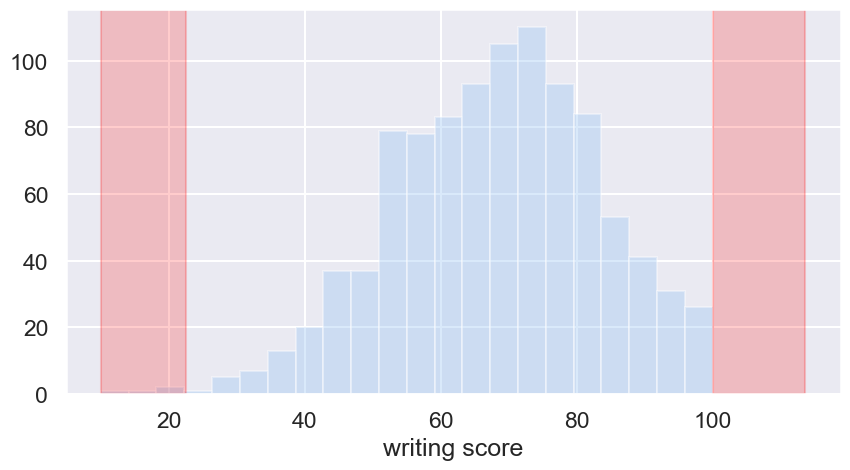

In [70]:
plt.figure(figsize = (10,5))
sns.distplot(df_2['writing score'], kde=False)
plt.axvspan(xmin = lower,xmax= df_2['writing score'].min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_2['writing score'].max(),alpha=0.2, color='red')

In [71]:
df_new = df_2[(df_2['writing score'] < upper) | (df_2['writing score'] > lower)]

In [72]:
df_3 = pd.read_csv("insurance.csv")
df_3.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [73]:
df_3.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [74]:
df_3.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<Axes: xlabel='charges', ylabel='Density'>

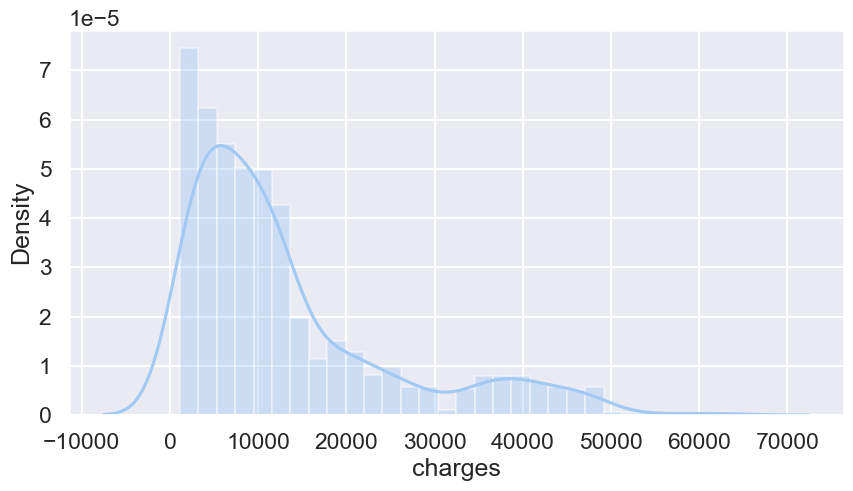

In [75]:
plt.figure(figsize = (10,5))
sns.distplot(df_3['charges'])

In [76]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers are",len(outliers))

In [77]:
out_zscore(df_3.charges)


Total number of outliers are 7


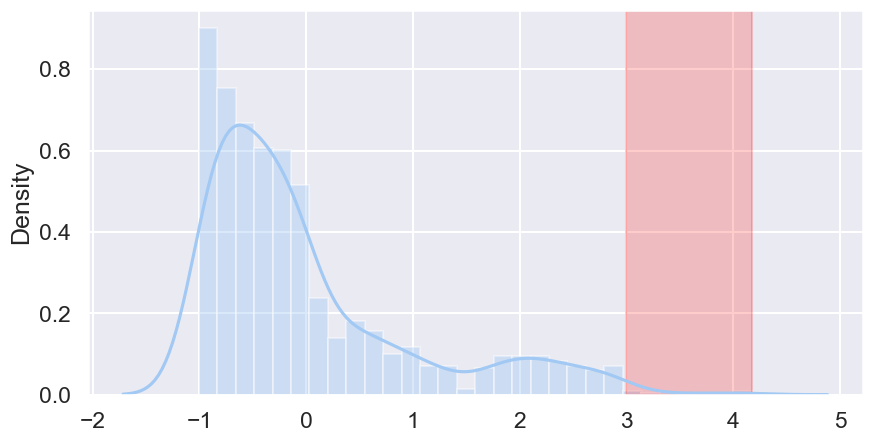

In [78]:
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red')

In [79]:
df_new = df_3[(df_3['charges'] < 3) | (df_3['charges'] > -3)]

In [80]:
df_new.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [81]:
df_new.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Isolation Forrest

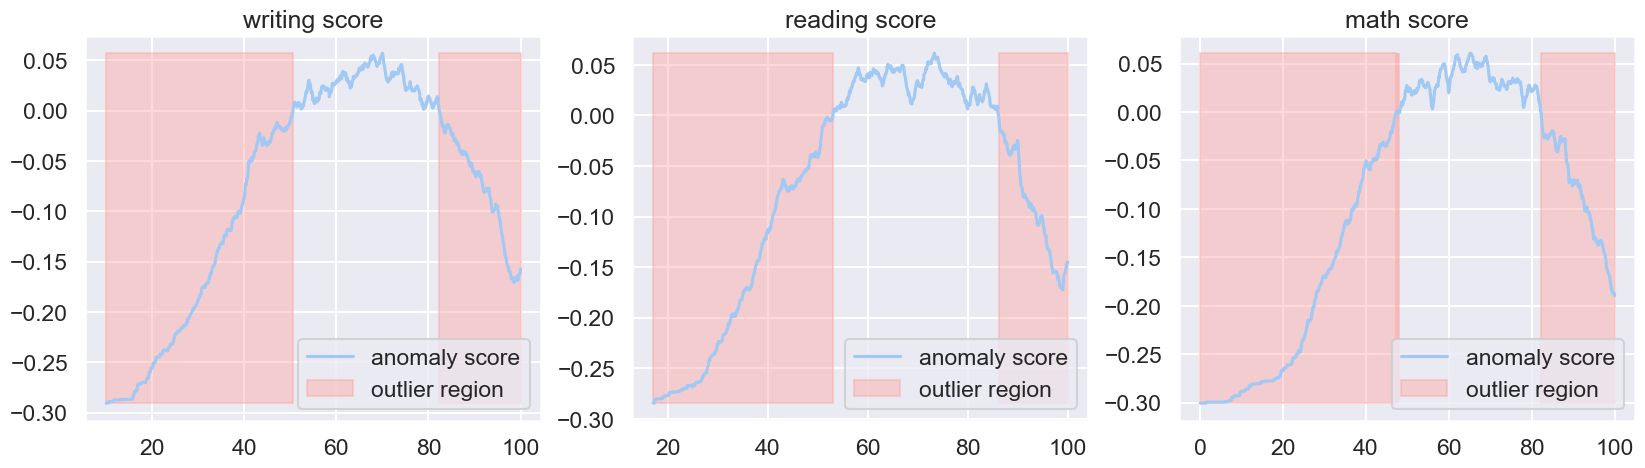

In [82]:
#Import necessary libraries
from sklearn.ensemble import IsolationForest
#The required columns
cols = ['writing score','reading score','math score']
#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df_2[column].values.reshape(-1,1))

    xx = np.linspace(df_2[column].min(), df_2[column].max(), len(df_2)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

In [83]:
X = df_3[['age','bmi']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [84]:
pd.Series(labels).value_counts()


 0    1312
-1      26
Name: count, dtype: int64

Text(0, 0.5, 'BMI')

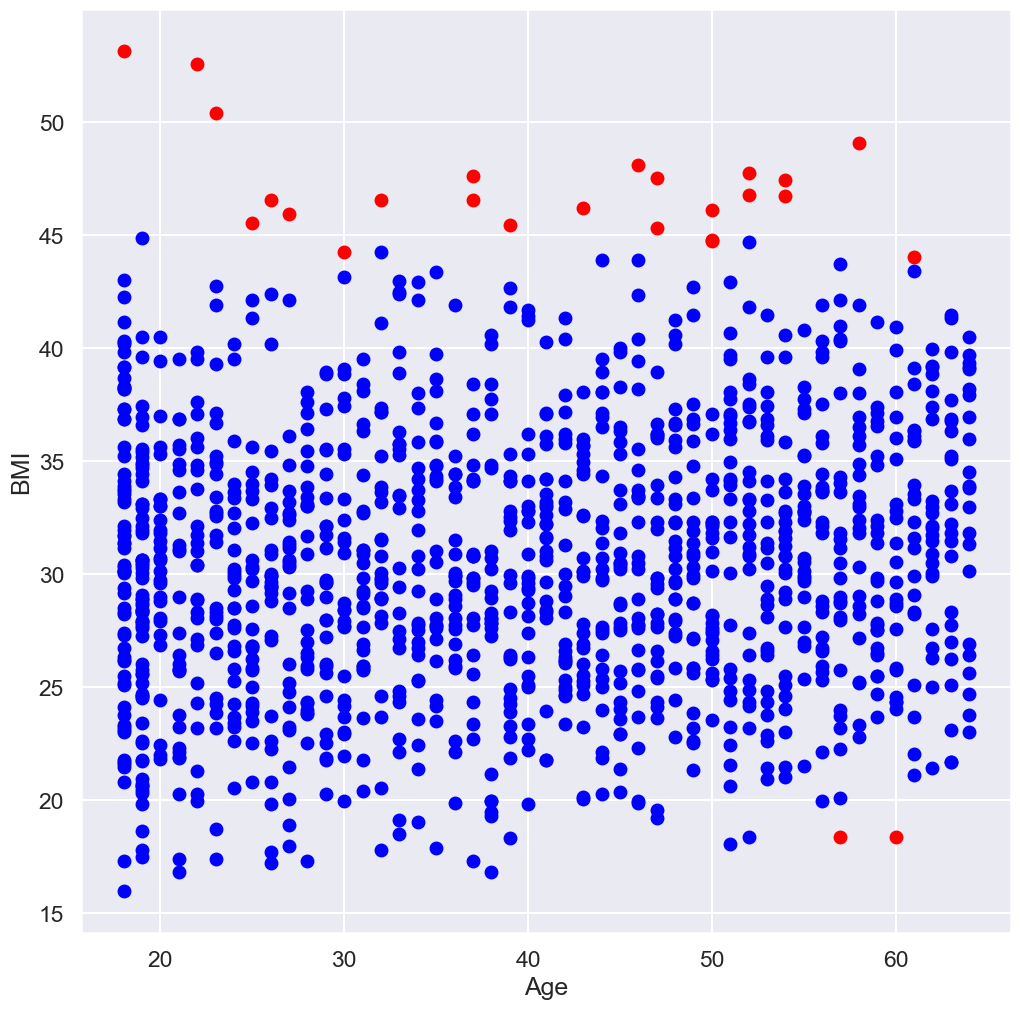

In [85]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age')
plt.ylabel('BMI')

**Local Outlier Factor Method(LOF)**

In [87]:
df_1_cleaned = df_1[['age', 'chol']].dropna()
X_cleaned = df_1_cleaned.values
y_pred = clf.fit_predict(X_cleaned)


In [88]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
y_pred = clf.fit_predict(X_imputed)

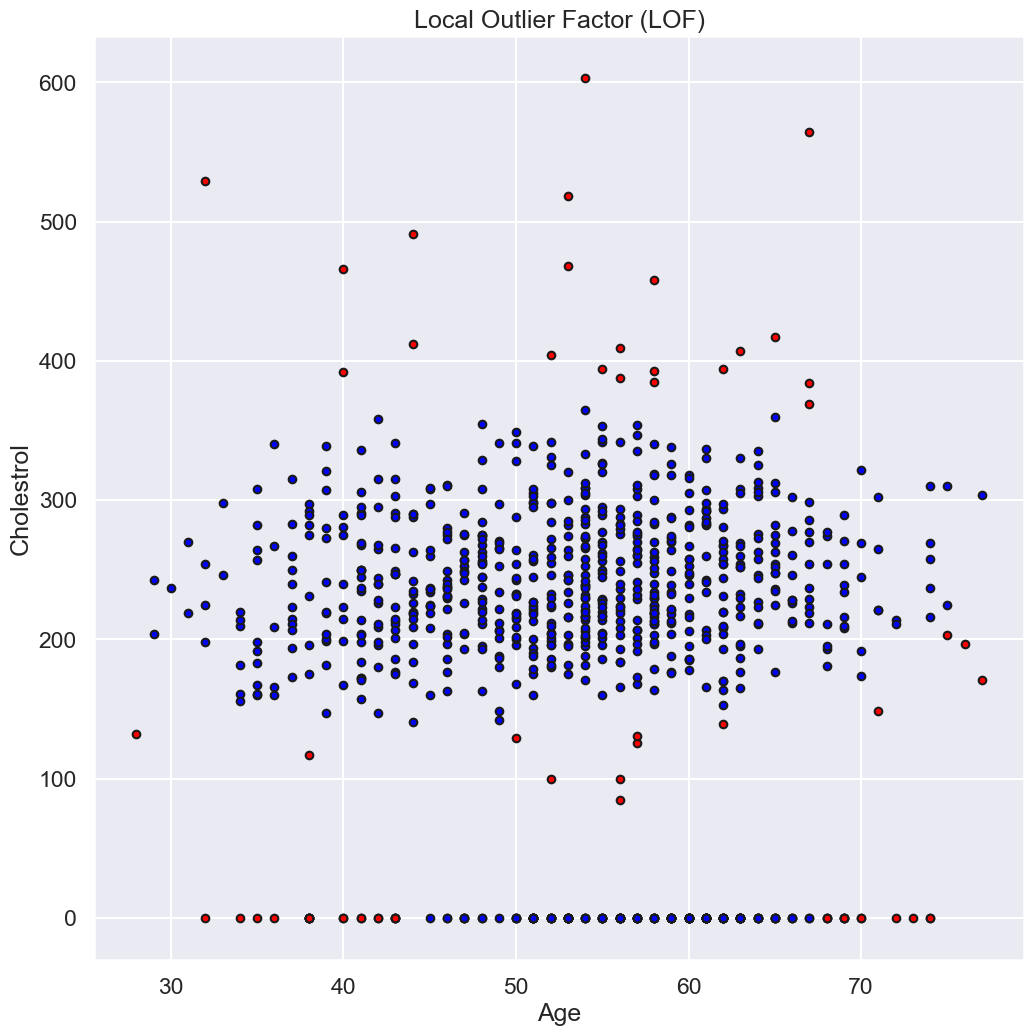

In [89]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Age');
plt.ylabel('Cholestrol');
plt.show()